In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)
from sklearn.metrics import jaccard_score
import umap
from sklearn.svm import SVC

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import balanced_accuracy_score

In [71]:
# data import
data = pd.read_csv('Training_Dataset.csv')
pairs = pd.read_csv("/Users/duanyueyun/Desktop/Capstone/notebooks (final)/Download apk/repackaging_pairs.txt")

In [72]:
print("Distribution of target:")
data['label'].value_counts()/data.shape[0]

Distribution of target:


1    0.816779
0    0.183221
Name: label, dtype: float64

In [73]:
# Delete useless features told by Shirish
data.drop(['Package_Name', 'ThumbPrint', 'Application_Category', 
        'Family_Name', 'Malware_Category', 'Malware/Benign',
       'sdkVersion', 'targetSdkVersion'], axis = 1, inplace = True)

In [74]:
# Drop features with 0 variance
data.drop(data.columns[data.nunique()==1].to_list(), axis = 1, inplace = True)

In [75]:
# drop duplicate rows
data = data[~data.duplicated(keep='first')]
y = data['label']

In [76]:
data.shape

(10951, 354)

# Training SVM Model

## Splitting Training and Test set

In [33]:
X=data.drop(columns=['label','SHA256'])
# Create dataset without sensor features in order to see if there's some improvement by adding sensor features
X_wo_sensors = X.drop(X.iloc[:, -29:].columns, axis = 1)
print(X.shape)
print(X_wo_sensors.shape)

(10951, 352)
(10951, 323)


In [34]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 123, 
                                                    stratify = y)

X_train_wo_sensor, X_test_wo_sensor, y_train_wo_sensor, y_test_wo_sensor = \
train_test_split(X_wo_sensors, y, test_size = 0.2, random_state = 123, stratify = y)

# Training SVM Model

In [198]:
model = SVC(class_weight='balanced')

In [199]:
avg_val_score = np.mean(cross_val_score(model, X_train, y_train, cv = 5,
                                       scoring = "balanced_accuracy"))
print('The mean test score of Logistic Regression model with sensor features is:', avg_val_score)

The mean test score of Logistic Regression model with sensor features is: 0.8623777654984905


In [200]:
avg_val_score = np.mean(cross_val_score(model, X_train_wo_sensor, y_train_wo_sensor, cv = 5,
                                       scoring = "balanced_accuracy"))
print('The mean test score of Logistic Regression model without sensor features is:', avg_val_score)

The mean test score of Logistic Regression model without sensor features is: 0.8634303022690357


## Tuning Hyperparameters

**1. Training on Dataset Including Sensor Features**

In [37]:
# Tune C of Logistic Regression
pipe_with_sensor = make_pipeline(SVC(class_weight='balanced'))

params = {'svc__kernel': ['poly', 'rbf'],
          'svc__C': [0.2, 0.5, 1, 10, 100]}

grid_with_sensor = GridSearchCV(pipe_with_sensor, param_grid = params,
                               scoring = "balanced_accuracy")
grid_with_sensor.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('svc', SVC(class_weight='balanced'))]),
             param_grid={'svc__C': [0.2, 0.5, 1, 10, 100],
                         'svc__kernel': ['poly', 'rbf']},
             scoring='balanced_accuracy')

In [38]:
result_with_sensor = pd.DataFrame(grid_with_sensor.cv_results_)

Text(0.5, 1.0, 'Mean Test Score of SVM with Different C (Including Sensor Features)')

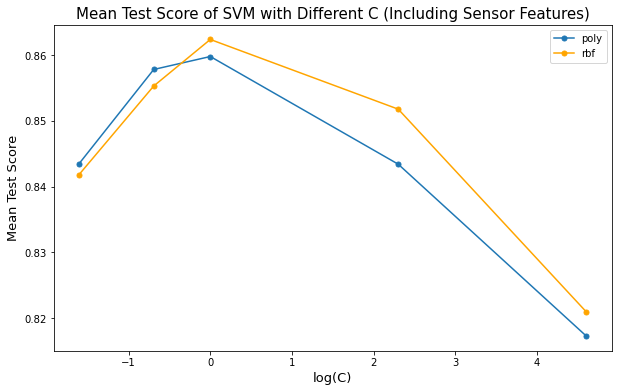

In [47]:
poly_scores = result_with_sensor[result_with_sensor['param_svc__kernel']=='poly']['mean_test_score']
rbf_scores = result_with_sensor[result_with_sensor['param_svc__kernel']=='rbf']['mean_test_score']
plt.figure(figsize = (10, 6))
plt.plot(np.log([0.2, 0.5, 1, 10, 100]), poly_scores, marker = 'o', markersize = 5,
        label='poly')
plt.plot(np.log([0.2, 0.5, 1, 10, 100]), rbf_scores, marker = 'o', markersize = 5, c='orange',
        label='rbf')
plt.legend()
plt.xlabel('log(C)', fontsize = 13)
plt.ylabel('Mean Test Score', fontsize = 13)
plt.title('Mean Test Score of SVM with Different C (Including Sensor Features)', fontsize = 15)

**2. Training on Dataset Not Including Sensor Features**

In [48]:
pipe_wo_sensor = make_pipeline(SVC(class_weight='balanced'))

params = {'svc__kernel': ['poly', 'rbf'],
          'svc__C': [0.2, 0.5, 1, 10, 100]}

grid_wo_sensor = GridSearchCV(pipe_wo_sensor, param_grid = params)
grid_wo_sensor.fit(X_train_wo_sensor, y_train_wo_sensor)

GridSearchCV(estimator=Pipeline(steps=[('svc', SVC(class_weight='balanced'))]),
             param_grid={'svc__C': [0.2, 0.5, 1, 10, 100],
                         'svc__kernel': ['poly', 'rbf']})

In [49]:
result_wo_sensor = pd.DataFrame(grid_wo_sensor.cv_results_)

Text(0.5, 1.0, 'Mean Test Score of SVM with Different C (Without Sensor Features)')

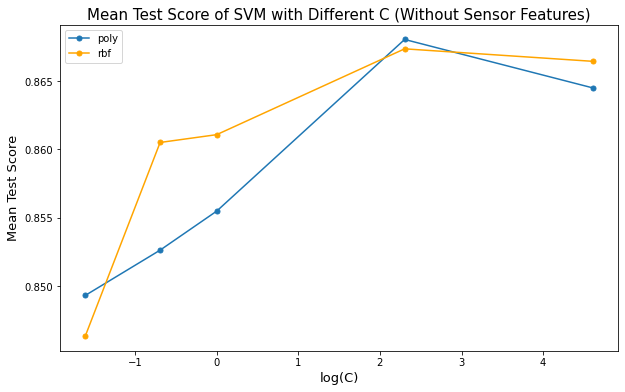

In [50]:
poly_scores2 = result_wo_sensor[result_wo_sensor['param_svc__kernel']=='poly']['mean_test_score']
rbf_scores2 = result_wo_sensor[result_wo_sensor['param_svc__kernel']=='rbf']['mean_test_score']
plt.figure(figsize = (10, 6))
plt.plot(np.log([0.2, 0.5, 1, 10, 100]), poly_scores2, marker = 'o', markersize = 5,
        label='poly')
plt.plot(np.log([0.2, 0.5, 1, 10, 100]), rbf_scores2, marker = 'o', markersize = 5, c='orange',
        label='rbf')
plt.legend()
plt.xlabel('log(C)', fontsize = 13)
plt.ylabel('Mean Test Score', fontsize = 13)
plt.title('Mean Test Score of SVM with Different C (Without Sensor Features)', fontsize = 15)

## Evaluation on Test Data

Adding sensor features improves balanced accuracy slightly.

In [51]:
y_pred_with_sensor = grid_with_sensor.predict(X_test)
y_pred_wo_sensor = grid_wo_sensor.predict(X_test_wo_sensor)

In [52]:
print("Test score with sensors:",  balanced_accuracy_score(y_test, y_pred_with_sensor))
print("Test score without sensors:", balanced_accuracy_score(y_test_wo_sensor, y_pred_wo_sensor))

Test score with sensors: 0.8410600593488347
Test score without sensors: 0.8191260675127823


In [53]:
data = pd.read_csv('Training_Dataset.csv')
data.drop_duplicates(inplace=True)
data.shape

(10951, 873)

In [54]:
X_test = X_test.merge(data[['label','SHA256', 'ThumbPrint']], left_index=True, right_index=True)
X_test['y_pred_with_sensor'] = y_pred_with_sensor
#X_test['y_pred_wo_sensor'] = y_pred_wo_sensor

In [58]:
# scores of top 10 authors
X_test['correct'] = X_test['label'] == X_test['y_pred_with_sensor']
summ = X_test[X_test['label']==0].groupby('ThumbPrint').agg(N=('SHA256','count'),
                                                      correct=('correct','sum'))\
.sort_values(['N','correct'], ascending=False).iloc[:10,:]
summ['score'] = summ['correct']/summ['N']
summ

,N,correct,score
ThumbPrint,,,
672C7E09D7971FEFF924CB9BB9DF501B068699D2,37,20.0,0.540541
61ED377E85D386A8DFEE6B864BD85B0BFAA5AF81,24,15.0,0.625000
F0CA270347F8E2D6D21F4F249BB6FA82AB6F83E3,17,10.0,0.588235
12B91A5CD3D72CC321BD51931937D318555A182D,4,4.0,1.000000
0750E92DADA81CD385EF1D48F741BA2F6C2C8413,2,2.0,1.000000
EF6437B4BA486551FBCC4FCB2FB126BB4B911BAB,2,1.0,0.500000
2567A99F17B580AABE2846936E4CDE5D77D74115,2,0.0,0.000000
030261EE682280189ADE9A056051855C5537480B,1,1.0,1.000000
06AFC9279994F21A880615B33F16FA6993149CD5,1,1.0,1.000000


In [67]:
# apps whose original/repackaged counterpart is in the data
s1 = X_test[(X_test['SHA256'].isin(sample_pairs['SHA256_ORIGINAL']))|
           (X_test['SHA256'].isin(sample_pairs['SHA256_REPACKAGE']))]
s1.shape

(909, 357)

In [68]:
# apps whose original/repackaged counterpart is not in the data:
s2 = X_test[(~X_test['SHA256'].isin(sample_pairs['SHA256_ORIGINAL']))&
           (~X_test['SHA256'].isin(sample_pairs['SHA256_REPACKAGE']))]
s2.shape

(1282, 357)

In [69]:
print("Overall accuracy:", X_test['correct'].mean())
print("Accuracy for apps whose original/repackaged counterpart is in the data:",
     s1['correct'].mean())
print("Accuracy for apps whose original/repackaged counterpart is not in the data:",
     s2['correct'].mean())

Overall accuracy: 0.8493838429940667
Accuracy for apps whose original/repackaged counterpart is in the data: 0.7183718371837183
Accuracy for apps whose original/repackaged counterpart is not in the data: 0.9422776911076443
